In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ["TRANSFORMERS_OFFLINE"] = "1"

import sys
import json
import glob
import torch

from PIL import Image

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

In [2]:
from matplotlib import pyplot
import seaborn as sns

In [3]:
from torch.optim import AdamW
from optimizers import Adan, Lookahead, AGC
from transformers import AutoTokenizer, AutoModel, CLIPTextModelWithProjection

In [4]:
INPUT_DIR = '../kcg-ml-image-pipeline/output/environmental/ranking_v1/'
PMT_PATH = 'data/ranking_v1/prompt.json'
# EMB_PATH = 'data/ranking_v1/bge_emb.npz'
EMB_PATH = 'data/ranking_v1/clip_emb.npz'

# MODEL_NAME = 'johngiorgi/declutr-base'
MODEL_NAME = 'openai/clip-vit-large-patch14'
# MODEL_NAME = 'BAAI/bge-base-en-v1.5'

BATCH_SIZE = 256

MAX_LENGTH = 77

LR = 1e-5

# load json

In [5]:
file_hashs = list()
positive_prompts = list()
negative_prompts = list()

for file_hash, info in json.load(open(PMT_PATH)).items():
    
    file_hashs.append(file_hash)
    positive_prompts.append(info['positive_prompt'])
    negative_prompts.append(info['negative_prompt'])

hash_to_index = {file_hash: i for i, file_hash in enumerate(file_hashs)}

# load rank data

In [6]:
paths = sorted(glob.glob(os.path.join(INPUT_DIR, 'ranking_data', '*.json')))

rank_pairs = list()
for path in tqdm(paths):
    js = json.load(open(path))
    if (js['image_1_metadata']['file_hash'] not in hash_to_index) or (js['image_2_metadata']['file_hash'] not in hash_to_index):
        continue
    rank_pairs.append((js['image_1_metadata']['file_hash'], js['image_2_metadata']['file_hash'], js['selected_image_index']))

  0%|          | 0/20790 [00:00<?, ?it/s]

# check conflicts

In [7]:
import networkx

In [8]:
graph = networkx.DiGraph()

In [9]:
for img_1, img_2, sel_id in rank_pairs:
    if sel_id == 0:
        graph.add_edge(img_2, img_1)
    else:
        graph.add_edge(img_1, img_2)

In [10]:
len(graph.nodes), len(graph.edges)

(21305, 20786)

In [11]:
try:
    networkx.find_cycle(graph)
    print('yes')
except:
    print('no')

yes


# check transitive relationship

In [12]:
trans_pairs = list()

for image_1_hash, d in networkx.all_pairs_shortest_path_length(graph):
    
    for image_2_hash, dist in d.items():
        
        if dist <= 1:
            continue
        
        trans_pairs.append((image_1_hash, image_2_hash, dist))
        
trans_pairs = pd.DataFrame(trans_pairs, columns=['image_1_hash', 'image_2_hash', 'dist'])
trans_pairs

,image_1_hash,image_2_hash,dist
0,94bd853c68996549ff8218ef41614fd4a55d17007f7526...,12625f58a1d54b802da347103e48d441104bd5535d7d69...,2
1,94bd853c68996549ff8218ef41614fd4a55d17007f7526...,eb69aa30f3d6ec24c498f9be24f745f21e5ee1ec9562f6...,2
2,94bd853c68996549ff8218ef41614fd4a55d17007f7526...,fd411205f1face47e5c30440c52006446ff121daabc1f1...,3
3,3e865d7defa7498ff3bd1b42e5327924fb3cd518fee612...,bc6b3962f6cba734e99ca8bf0ee380a3d3793c2ef63490...,2
4,ae5c5cf41e086a6c57f870541f02af00d9fd83bcb12913...,711f811b470b7cf76efdec750c1378644ca47c615e640d...,2
...,...,...,...
11468,6aaf0b10be77a1128456769d61aa8cd42c3adbfb82c749...,28815586ad87b725886e4d5bc8993a675eb8d97ded62b2...,3
11469,6aaf0b10be77a1128456769d61aa8cd42c3adbfb82c749...,6e1ec99e9086ca1a279692f755c58b9f257ee45f04609e...,4
11470,3afb53351878854cdf26926a00a35c260deb373587080a...,70292538d96042372703807148127983d55f2252d93898...,2
11471,deb5ce6e41f2983c075d9f3576d0ff1a66b5de0553ddc9...,c01cc3975673d628fc476de51261ebd925c8e401976a0b...,2


# build dataset

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [14]:
positive_encodings = tokenizer(
    positive_prompts,
    truncation=True, max_length=MAX_LENGTH, return_length=True,
    return_overflowing_tokens=False, padding="max_length", return_tensors="pt"
)["input_ids"]

negative_encodings = tokenizer(
    negative_prompts,
    truncation=True, max_length=MAX_LENGTH, return_length=True,
    return_overflowing_tokens=False, padding="max_length", return_tensors="pt"
)["input_ids"]

In [15]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1_hash', 'image_2_hash', 'selected_image_index'])

rank_pairs

,image_1_hash,image_2_hash,selected_image_index
0,42ee13e91ac7b709f896077d98edbcb38b931a13306446...,94bd853c68996549ff8218ef41614fd4a55d17007f7526...,0
1,61ccff95c06b49b9f1bc4abe15af2598bc6e93b6ed9a68...,3d85873e61357ffb38928e22987881c893974b3c7b7720...,0
2,93d5b322d9c6b8d3580194edbea662fe28c180dcca9c2b...,4fda19572c7e06ce84004133a05881fb234baf6549f5c2...,1
3,6bfc50f135f87f180f8a9473bd781e634aebc5e319cc3f...,3e865d7defa7498ff3bd1b42e5327924fb3cd518fee612...,0
4,38ce0e30d209fb4557266e539771b2e98aa5628f352acf...,ae5c5cf41e086a6c57f870541f02af00d9fd83bcb12913...,0
...,...,...,...
20784,9d7aff5a30da7b273d16c07a9a6f9daf14ae8ed61d7bd7...,7266b827572fc60cf8bccf5b6254a64dac36594fe06e7d...,0
20785,deb5ce6e41f2983c075d9f3576d0ff1a66b5de0553ddc9...,d2e88eb8cad25a573bc3a1c694cdbc943de2066c99930a...,1
20786,b9d3ee83e298901067830713e5e43eda8b4c10e96d9a6b...,b022e36aef205e4d38a1251d71e2786f8568a4e2d9b060...,1
20787,96ad2f1eef6e9ad0e82f19190cd2df3422af942cad918f...,564018a5784243393f81ac52c02aa71227ea741a363cdb...,0


In [16]:
ordered_pairs = [((image_1_hash, image_2_hash) if selected_image_index == 0 else (image_2_hash, image_1_hash)) for image_1_hash, image_2_hash, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1_hash', 'image_2_hash'])

In [17]:
train_pairs, val_pairs = train_test_split(ordered_pairs, test_size=0.2, random_state=42)

In [18]:
len((set(rank_pairs['image_1_hash']) | set(rank_pairs['image_2_hash'])) | set(file_hashs))

21305

## build feature

In [19]:
def build_feature(index_1, index_2, use_positive=True, use_negative=False):
    
    results = list()
    if use_positive:
        results.append(torch.stack([positive_encodings[index_1], positive_encodings[index_2]], dim=-1))
    if use_negative:
        results.append(torch.stack([negative_encodings[index_1], negative_encodings[index_2]], dim=-1))
        
    return results

In [20]:
train_data = list()
for image_1_hash, image_2_hash in train_pairs.itertuples(index=False, name=None):
    index_1, index_2 = hash_to_index[image_1_hash], hash_to_index[image_2_hash]
    train_data.append(build_feature(index_1, index_2, use_positive=True, use_negative=False)[0])
train_data = torch.stack(train_data, axis=0)

val_data = list()
for image_1_hash, image_2_hash in val_pairs.itertuples(index=False, name=None):
    index_1, index_2 = hash_to_index[image_1_hash], hash_to_index[image_2_hash]
    val_data.append(build_feature(index_1, index_2, use_positive=True, use_negative=False)[0])
val_data = torch.stack(val_data, axis=0)

train_data.shape, val_data.shape

(torch.Size([16631, 77, 2]), torch.Size([4158, 77, 2]))

In [21]:
# ext_data = list()
# for image_1_hash, image_2_hash in trans_pairs[['image_1_hash', 'image_2_hash']].itertuples(index=False, name=None):
#     index_1, index_2 = hash_to_index[image_1_hash], hash_to_index[image_2_hash]
#     ext_data.append(build_feature(index_1, index_2, use_positive=True, use_negative=False, use_mask=True)[0])
# ext_data = np.stack(ext_data, axis=0)
# ext_data.shape

# train model

In [22]:
if BATCH_SIZE > 0:
    train_dataset = train_data.pin_memory()
    val_dataset = val_data.pin_memory()
else:
    train_dataset = train_data.cuda()
    val_dataset = val_data.cuda()

In [ ]:
model = CLIPTextModelWithProjection.from_pretrained(MODEL_NAME, projection_dim=1, ignore_mismatched_sizes=True)

In [24]:
# parameters = list(model.parameters())
parameters = list(model.text_model.final_layer_norm.parameters()) + list(model.text_model.parameters())

optimizer = AdamW(parameters, lr=LR, weight_decay=1e-3)
# optimizer = Adan(parameters, lr=LR, weight_decay=1e-3)
# optimizer = Lookahead(optimizer)
# optimizer = AGC(optimizer)
warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, [lambda step: step / 100. if step < 100 else 1.])

/home/xhxie/snap/kk-digital/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/torch/optim/adamw.py:50: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super().__init__(params, defaults)


In [25]:
model = torch.nn.DataParallel(model.cuda())
# model = model.cuda()

In [26]:
scaler = torch.cuda.amp.GradScaler()
    
bces, accs = list(), list()

for epoch in tqdm(range(2)):
    
    model.train()
    
    if BATCH_SIZE > 0:
        label = torch.zeros((BATCH_SIZE,), device='cuda').long()
        loader = range(BATCH_SIZE, train_dataset.shape[0], BATCH_SIZE)
    else:
        label = torch.zeros((train_dataset.shape[0],), device='cuda').long()
        loader = [train_dataset.shape[0]]
    
    for i in loader:
    
        if BATCH_SIZE > 0:
            x = train_dataset[i-BATCH_SIZE:i]
        else:
            x = train_dataset
        
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(True):

            y0 = model(x[..., 0].cuda()).text_embeds
            y1 = model(x[..., 1].cuda()).text_embeds
            
            y = torch.concat([y0, y1], dim=-1)

        # backward

        bce = torch.nn.functional.cross_entropy(y, label)

        acc = (y.argmax(dim=-1) == 0).float().mean()

        loss = bce

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        warmup.step()

        bces.append(bce.detach().cpu().numpy())
        accs.append(acc.detach().cpu().numpy())
        
    if (epoch + 1) % 1 == 0:
        
        model.eval()

        val_bces, val_accs = list(), list()

        with torch.no_grad():

            with torch.cuda.amp.autocast(True):

                if BATCH_SIZE > 0:
                    loader = range(BATCH_SIZE, val_dataset.shape[0], BATCH_SIZE)
                else:
                    loader = [val_dataset.shape[0]]

                for i in loader:

                    if BATCH_SIZE > 0:
                        x = val_dataset[i:i+BATCH_SIZE]
                    else:
                        x = val_dataset

                    y0 = model(x[..., 0].cuda()).text_embeds
                    y1 = model(x[..., 1].cuda()).text_embeds

                    y = torch.concat([y0, y1], dim=-1)

                    label = torch.zeros((y.shape[0],), device='cuda').long()

                    bce = torch.nn.functional.cross_entropy(y, label)

                    acc = (y.argmax(dim=-1) == 0).float().mean()

                    val_bces.append(bce.detach().cpu().numpy())
                    val_accs.append(acc.detach().cpu().numpy())

        print(f'{epoch+1}\t{np.mean(bces):.4f} {np.mean(accs):.4f} {np.mean(val_bces):.4f} {np.mean(val_accs):.4f}')
    
        bces, accs = list(), list()

  0%|          | 0/2 [00:00<?, ?it/s]

1	0.5503 0.6932 0.4090 0.7847
2	0.3799 0.8126 0.3708 0.8281


# analysis

## val set distribution

In [27]:
model.eval()

y0s, y1s = list(), list()

with torch.no_grad():

    with torch.cuda.amp.autocast(True):

        if BATCH_SIZE > 0:
            loader = range(BATCH_SIZE, val_dataset.shape[0], BATCH_SIZE)
        else:
            loader = [val_dataset.shape[0]]

        for i in loader:

            if BATCH_SIZE > 0:
                x = val_dataset[i:i+BATCH_SIZE]
            else:
                x = val_dataset

            y0 = model(x[..., 0].cuda()).text_embeds
            y1 = model(x[..., 1].cuda()).text_embeds

            y0s.append(y0.detach().cpu().numpy())
            y1s.append(y1.detach().cpu().numpy())
            
y0 = np.concatenate(y0s, axis=0)
y1 = np.concatenate(y1s, axis=0)

val_delta = (y0 - y1)[..., 0]

Text(0.5, 1.0, '')

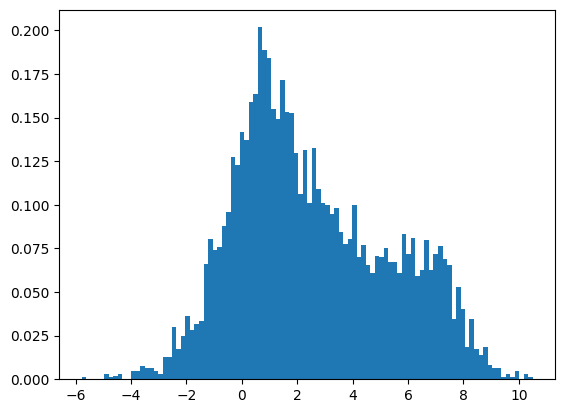

In [28]:
_ = pyplot.hist(val_delta, bins=100, density=True)
pyplot.title('')

## score distribution

In [ ]:
model.eval()

scores = list()

with torch.no_grad():
    with torch.cuda.amp.autocast(True):
        
        if BATCH_SIZE > 0:
            loader = range(BATCH_SIZE, positive_encodings.shape[0], BATCH_SIZE)
        else:
            loader = [positive_encodings.shape[0]]

        for i in loader:

            if BATCH_SIZE > 0:
                x = positive_encodings[i:i+BATCH_SIZE]
            else:
                x = positive_encodings

            score = model(torch.tensor(x).cuda()).text_embeds
            scores.append(score[..., 0].detach().cpu().numpy())
        
score = np.concatenate(scores, axis=0)

In [ ]:
_ = pyplot.hist(score, bins=100, density=True)
pyplot.show()

## prepare for visualization

In [ ]:
js = json.load(open(PMT_PATH))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
def get_details(prompt_sequences: list, embedding_sequences, topk=3):
    
    encoding = tokenizer(
        prompt_sequences,
        truncation=True, max_length=77, return_length=True,
        return_overflowing_tokens=False, padding="max_length", return_tensors="pt"
    )
    
    input_ids = encoding['input_ids']
    
    x = torch.tensor(embedding_sequences).half()
    x = x.view(-1, *x.shape[-2:]).permute(0, 2, 1)

    model.eval()

    with torch.no_grad():

        with torch.cuda.amp.autocast(True):

            attn, scores, score = model(x.cuda(), return_all=True)

            attn = attn.detach().cpu().numpy()
            scores = scores.detach().cpu().numpy()
            score = score.detach().cpu().numpy()
            
    results = list()

    for t_is, t_as, t_ss, s in zip(input_ids, attn, scores, score):

        tokens = tokenizer.convert_ids_to_tokens(t_is)
        
        tags = list()
        last = ([], [], [])
        for token, t_a, t_s in zip(tokens, t_as[0], t_ss[0]):

            token = token.replace('</w>', '')

            last_tokens, last_as, last_ss = last

            if token[0] in ['<', '['] and token[-1] in ['>', ']']:
                if len(last_tokens) > 0:
                    tags.append((' '.join(last_tokens), sum(last_as), sum(i*j for i, j in zip(last_as, last_ss)) / sum(last_as)))
                tags.append((token, t_a, t_s))
                last = ([], [], [])
            else:
                last_tokens.append(token)
                last_as.append(t_a)
                last_ss.append(t_s)

                if ',' in token:
                    tags.append((' '.join(last_tokens), sum(last_as), sum(i*j for i, j in zip(last_as, last_ss)) / sum(last_as)))
                    last = ([], [], [])

        last_tokens, last_as, last_ss = last
        if len(last_tokens) > 0:
            tags.append((' '.join(last_tokens), sum(last_as), sum(i*j for i, j in zip(last_as, last_ss)) / sum(last_as)))
            
        t_texts, t_attns, t_scores = zip(*tags)
        
        topk_ids = np.argsort(t_attns)[::-1][:topk]

        results.append([s[0]] + sum([[t_texts[i], t_attns[i], t_scores[i]] for i in topk_ids], start=[]))     

#         topk_ids = np.argsort(as[0])[::-1][:topk]

#         results.append((s[0],) + sum(zip([tokens[i].replace('</w>', '') for i in topk_ids], as[0, topk_ids], ss[0, topk_ids]), start=()))     
    
    results = pd.DataFrame(results, columns=['score'] + sum([[f'{i+1}-token', f'{i+1}-weight', f'{i+1}-score'] for i in range(topk)], start=[]))
    
    return results

In [ ]:
def select_samples(indices, n_select):
    
    selected = np.random.choice(indices, n_select, False)
    
    file_paths = [js[file_hashs[i]]['file_path'] for i in selected]
    file_paths = [i.replace('_embedding.msgpack', '.jpg') for i in file_paths]
    
    images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/', i))) for i in file_paths])
    images = images.reshape(-1, int(n_select ** 0.5), *images.shape[-3:])
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    
    images = Image.fromarray(images).resize((512, 512))
    
    return selected, images

## show top score samples

In [ ]:
threshold = np.quantile(score, q=0.95)
selected, images = select_samples(np.arange(score.shape[0])[score > threshold], n_select=9)

threshold

In [ ]:
images

In [ ]:
get_details(
    [js[i]['positive_prompt'] for i in file_hashs[selected]], 
    positive_last_hidden_states_with_mask[selected]
)

## show lowest score samples

In [ ]:
threshold = np.quantile(score, q=0.05)
selected, images = select_samples(np.arange(score.shape[0])[score < threshold], n_select=9)

threshold

In [ ]:
images

In [ ]:
get_details(
    [js[i]['positive_prompt'] for i in file_hashs[selected]], 
    positive_last_hidden_states_with_mask[selected]
)

## show lowest delta samples

In [ ]:
n_select = 6

# threshold = np.quantile(val_delta, q=0.05)
# indices = val_pairs.index[np.arange(val_delta.shape[0])[val_delta < threshold]]
# selected = np.random.choice(indices, n_select, False)

selected = val_pairs.index[np.argsort(val_delta)[:n_select]]

indices_1 = [hash_to_index[i] for i in val_pairs.loc[selected, 'image_1_hash']]
indices_2 = [hash_to_index[i] for i in val_pairs.loc[selected, 'image_2_hash']]

In [ ]:
file_paths = [js[file_hashs[i]]['file_path'] for i in indices_1]
file_paths = [i.replace('_embedding.msgpack', '.jpg') for i in file_paths]

images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/', i))) for i in file_paths])
images_1 = np.concatenate(images, axis=-2)

file_paths = [js[file_hashs[i]]['file_path'] for i in indices_2]
file_paths = [i.replace('_embedding.msgpack', '.jpg') for i in file_paths]

images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/', i))) for i in file_paths])
images_2 = np.concatenate(images, axis=-2)

images = np.concatenate([images_1, images_2], axis=-3)

images = Image.fromarray(images).resize((512 * n_select // 2, 512))

In [ ]:
images

In [ ]:
get_details(
    [js[i]['positive_prompt'] for i in file_hashs[indices_1]], 
    positive_last_hidden_states_with_mask[indices_1]
)

In [ ]:
get_details(
    [js[i]['positive_prompt'] for i in file_hashs[indices_2]], 
    positive_last_hidden_states_with_mask[indices_2]
)